In [1]:
import torch
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from itertools import product

%matplotlib inline

In [2]:
class Shape:
    def __init__(self):
        pass
    def get_distance(self, x, y):
        raise NotImplementedError("Abstract class have not this method!")

In [3]:
class Circle(Shape):
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
    def get_score(self, x, y):
        d = np.sqrt((x - self.x) ** 2 + (y - self.y) ** 2)
        if d > self.r:
            return 0
        else:
            return 1 - d / self.r
    def get_distance(self, x, y):
        return np.abs(np.sqrt((x - self.x) ** 2 + (y - self.y) ** 2) - self.r)
    def get_vector_ditance(self, x, y, dx, dy):
        x -= self.x
        y -= self.y
        l = np.sqrt(dx ** 2 + dy ** 2)
        dx /= l
        dy /= l
        a = dx ** 2 + dy ** 2
        b = 2 * dx * x + 2 * dy * y
        c = x ** 2 + y ** 2 - self.r ** 2
        d = b ** 2 - 4 * a * c
        if d < 0:
            return np.inf
        else:
            t1 = (-b - np.sqrt(d)) / (2 * a)
            t2 = (-b + np.sqrt(d)) / (2 * a)
            if t2 < t1:
                t2, t1 = t1, t2
            if t2 < 0:
                return np.inf
            else:
                if t1 < 0:
                    return t2
                else:
                    return t1

In [4]:
class Line(Shape):
    def __init__(self, p1, p2):
        x1, y1 = p1
        x2, y2 = p2
        self.a = y1 - y2
        self.b = x2 - x1
        self.c = -(self.a * x1 + self.b * y1)
    def get_distance(self, x, y):
        return abs((self.a * x + self.b * y + self.c) / np.sqrt(self.a ** 2 + self.b ** 2))

In [5]:
class Segment(Shape):
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def get_distance(self, x, y):
        pr = (x - self.p1[0]) * (self.p2[0] - self.p1[0]) + (y - self.p1[1]) * (self.p2[1] - self.p1[1])
        if pr > 0 and pr < (self.p2[0] - self.p1[0]) ** 2 + (self.p2[1] - self.p1[1]) ** 2:
            return Line(self.p1, self.p2).get_distance(x, y)
        return min(np.hypot(x - self.p1[0], y - self.p1[1]), np.hypot(x - self.p2[0], y - self.p2[1]))

In [6]:
class AbstractField:
    def __init__(self):
        pass
    
    def get_max_dist(self):
        raise NotImplementedError("Abstract class have not this method!")
    
    def move(self, x, y, dx, dy):
        raise NotImplementedError("Abstract class have not this method!")

In [7]:
class CircleField:
    def __init__(self, r, obst, exit = None):
        self.r = r
#         print(r, obst, exit)
        self.obst = obst
        self.exit = exit
        
    def get_max_dist(self):
        return self.r * 2
        
    def move(self, x, y, dx, dy):
        l = np.sqrt(dx ** 2 + dy ** 2)
        if len(self.obst):
            min_dist = min(map(lambda c: c.get_vector_ditance(x, y, dx, dy), self.obst)) - 1e-5
        else:
            min_dist = self.r * 3
        min_dist = min(min_dist, Circle(0, 0, self.r).get_vector_ditance(x, y, dx, dy))
        if min_dist < l:
            dx *= min_dist / l
            dy *= min_dist / l
        if self.exit:
            return (x + dx, y + dy), self.exit.get_score(x + dx, y + dy)
        else:
            return (x + dx, y + dy)

In [8]:
def array_draw_objects(x0, x1, y0, y1, sz, objs, r, g, b, progress_bar = False):
    d = 5e-3 * (x1 - x0)
    ans = np.zeros((sz, sz, 3), dtype=np.float)
    coords = product(range(sz), range(sz))
    if progress_bar:
        coords = tqdm_notebook(list(coords))
    for i, j in coords:
            x = x0 + i / sz * (x1 - x0)
            y = y0 + j / sz * (y1 - y0)
            for o in objs:
                s = o.get_distance(x, y)
                if s < d:
                    ans[i][j][0] = r
                    ans[i][j][1] = g
                    ans[i][j][2] = b
    return ans

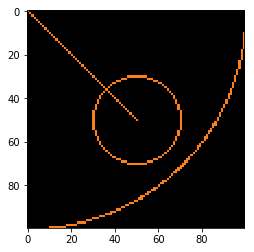

In [9]:
plt.imshow(array_draw_objects(0, 1, 0, 1, 100, [Circle(0, 0, 1), Circle(0.5, 0.5, 0.2), Segment((0, 0), (0.5, 0.5))], 1, 0.5, 0.1))

In [10]:
class AbstractModel:
    def __init__(self, field : AbstractField, x, y):
        self.field = field
        self.x = x
        self.y = y
    def move(self):
        raise NotImplementedError("Abstract class have not this method!")
    def get_neurons(self):
        raise NotImplementedError("Abstract class have not this method!")

In [11]:
class RandomModel(AbstractModel):
    def __init__(self, field : AbstractField, x, y, step, cover, neurons_count):
        AbstractModel.__init__(self, field, x, y)
        self.step = step
        self.cover = cover
        self.neurons_count = neurons_count
    def move(self):
        ang = np.random.random() * 2 * np.pi
        dx = self.step * np.cos(ang)
        dy = self.step * np.sin(ang)
        self.x, self.y = self.field.move(self.x, self.y, dx, dy)
    def _add_random_neurons(self, positions, place_neurons):
        ans = np.random.rand(self.neurons_count)
        for i, x in enumerate(positions):
            ans[x] = place_neurons[i]
        return ans
    def get_neurons(self):
        positions = random.sample(list(range(self.neurons_count)), len(self.cover))
        return self._add_random_neurons(positions, [c.get_score(self.x, self.y) for c in self.cover])

In [12]:
a = RandomModel(CircleField(10, []), 0, 0, 2, [Circle(0, 0, 1)], 10)
a.move()
print(a.get_neurons())

[0.92926318 0.03568313 0.63280642 0.33275433 0.76513193 0.32104159
 0.74678582 0.         0.30181719 0.18440461]


In [13]:
class NNModel(AbstractModel):
    def __init__(self, field : AbstractField, x, y, net):
        AbstractModel.__init__(self, field, x, y)
        self.net = net
        
    def move(self):
        raise NotImplementedError("Abstract class have not this method!")
    def get_neurons(self):
        raise NotImplementedError("Abstract class have not this method!")

In [14]:
action_pool = []
max_action_poll_size = 10 ** 3
cur_pos = 0
def add_action(state, act, new_state, reg):
    global cur_pos
    global max_action_poll_size
    if len(action_pool) < max_action_poll_size:
        action_pool.append((state, act, new_state, reg))
    else:
        action_pool[cur_pos] = (state, act, new_state, reg)
        cur_pos += 1
        cur_pos %= max_action_poll_size

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.l1 = torch.nn.Linear(16, 100)
        self.l2 = torch.nn.Linear(100, 100)
        self.l3 = torch.nn.Linear(100, 8)
    
    def forward(self, x, return_neurons = False):
        x = x.view(-1, 16)
        x = self.l1(x)
        x = torch.nn.functional.relu(x)
        if return_neurons:
            neurons = x
        x = self.l2(x)
        x = torch.nn.functional.relu(x)
        if return_neurons:
            neurons = torch.cat((neurons, x), dim=1)
        x = self.l3(x)
        if x.size()[0] == 1:
            x = x.view(8)
        if return_neurons:
            return x, neurons
        else:
            return x

In [24]:
gamma = 0.9
eps = 0.1
batch_size = 100
random.seed(42)
torch.manual_seed(42)
net = Net()
opt = torch.optim.Adam(net.parameters())
action_pool = []

r = 100
def random_circle(r):
    ang = random.random() * 2 * np.pi
    rr = random.random() * r
    return Circle(rr * np.cos(ang), rr * np.sin(ang), r / 10)
base_field = CircleField(r, [random_circle(r) for i in range(3)], random_circle(r))

In [25]:
from copy import deepcopy
delta = []
for dx in range(-1, 2):
    for dy in range(-1, 2):
        if dx or dy:
            delta.append((dx, dy))
def get_state(field, x, y):
    ans = np.zeros(16)
    md = field.get_max_dist()
    for i, (dx, dy) in enumerate(delta):
        ans[i] = field.exit.get_vector_ditance(x, y, dx, dy) or md
        if ans[i] > md:
            ans[i] = md
        (tx, ty), _ = field.move(x, y, dx * md, dy * md)
        ans[i + 8] = np.hypot(x - tx, y - ty)
    return torch.Tensor(ans)

for e in range(15):
    field = deepcopy(base_field)
    x = y = None
    while x == None:
        ang = np.random.random() * 2 * np.pi
        d = np.random.random() * r
        x = d * np.cos(ang)
        y = d * np.sin(ang)
        if field.exit.get_score(x, y):
            x = y = None
        else:
            for o in field.obst:
                if o.get_score(x, y):
                    x = y = None
                    break
    for i in range(100):
        state = get_state(field, x, y)
        if random.random() < eps:
            act = random.randint(0, 7)
        else:
            q = net(state).view(-1)
            act = torch.argmax(q.detach())
        old_state = torch.tensor(state)
#         print(old_state)
        old_dist = np.hypot(field.exit.x - x, field.exit.y - y)
        dx, dy = delta[act]
        step = field.r / 100
        ox, oy = x, y
        (x, y), e = field.move(x, y, dx * step, dy * step)
        new_dist = np.hypot(field.exit.x - x, field.exit.y - y)
        rew = old_dist - new_dist
        add_action(old_state, act, state, rew)
        if len(action_pool) == max_action_poll_size:
            batch = random.sample(action_pool, batch_size)
            new_states = list(map(lambda x: x[2].view(-1), batch))
            new_states = torch.cat(new_states)
            old_states = list(map(lambda x: x[0].view(-1), batch))
            old_states = torch.cat(old_states)
            rews = list(map(lambda x: x[3], batch))
            rews = torch.Tensor(rews)
            acts = list(map(lambda x: x[1], batch))
            acts = torch.LongTensor(acts)
            qs = net(new_states)
            qs = torch.max(qs, dim=1)[0]
            qs = qs * gamma + rews
#             qs = rews
            opt.zero_grad()
            rqs = net(old_states)
            rqs = torch.cat(list(map(lambda x: x[0][x[1]].view(1), zip(rqs, acts))))
            loss = ((qs - rqs) ** 2).mean()
            print(loss.detach())
            loss.backward()
            opt.step()
        if e:
            break
#     plt.imshow(array_draw_objects(-r, r, -r, r, 100, field.obst, 1.0, 1.0, 1.0) +
#         array_draw_objects(-r, r, -r, r, 100, [field.exit], 1.0, 0.0, 1.0) +
#         array_draw_objects(-r, r, -r, r, 100, [Circle(x, y, 1)], 0.0, 1.0, 0.0))

tensor(31.7523)
tensor(16.1150)
tensor(7.1626)
tensor(4.7172)
tensor(8.7221)
tensor(7.0295)
tensor(4.6665)
tensor(3.6939)
tensor(3.8071)
tensor(4.9183)
tensor(1.5749)
tensor(5.7612)
tensor(2.2193)
tensor(2.9903)
tensor(2.5921)
tensor(2.8760)
tensor(3.0061)
tensor(2.3033)
tensor(2.1437)
tensor(1.5611)
tensor(1.4494)
tensor(1.4968)
tensor(0.8453)
tensor(0.9564)
tensor(2.0568)
tensor(2.4768)
tensor(2.1965)
tensor(1.8730)
tensor(2.6896)
tensor(1.3214)
tensor(1.1808)
tensor(0.7741)
tensor(1.1156)
tensor(1.2435)
tensor(1.2871)
tensor(1.7013)
tensor(1.1968)
tensor(1.5149)
tensor(0.7373)
tensor(0.9265)
tensor(0.9619)
tensor(1.0301)
tensor(0.5593)
tensor(1.0500)
tensor(1.3319)
tensor(0.5406)
tensor(0.6849)
tensor(0.7412)
tensor(0.9016)
tensor(0.7771)
tensor(0.7612)
tensor(0.6736)
tensor(2.0702)
tensor(0.6457)
tensor(1.3666)
tensor(0.3829)
tensor(0.5079)
tensor(0.5307)
tensor(0.6937)
tensor(0.5503)
tensor(0.5143)
tensor(0.8580)
tensor(0.7492)
tensor(0.6024)
tensor(0.5920)
tensor(0.5682)
tensor(0

In [31]:
log = []
for i in tqdm_notebook(range(100)):
    field = deepcopy(base_field)
    arr = array_draw_objects(-r, r, -r, r, 200, [Circle(0, 0, r)], 0, 0, 0.5)
    arr += array_draw_objects(-r, r, -r, r, 200, [field.exit], 0.5, 0, 0.5)
    arr += array_draw_objects(-r, r, -r, r, 200, field.obst, 0.5, 0, 0)
    x = y = None
    while x == None:
        ang = np.random.random() * 2 * np.pi
        d = np.random.random() * r
        x = d * np.cos(ang)
        y = d * np.sin(ang)
        for o in field.obst:
            if o.get_score(x, y):
                x = y = None
                break
    itrs = 150
    step = r / 100
    segments = []
    for i in range(itrs):
        qs, neurons = net(get_state(field, x, y), True)
        log.append(neurons)
        dx, dy = delta[torch.argmax(qs.detach())]
        (nx, ny), e = field.move(x, y, dx * step, dy * step)
        segments.append(Segment((x, y), (nx, ny)))
        if e:
            break
        x, y = nx, ny
#     arr += array_draw_objects(-r, r, -r, r, 200, segments, 0.5, 0.5, 0, progress_bar=True)
#     plt.imshow(arr)

In [19]:
print(delta)

[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]


In [32]:
print(len(log))

11500
